### Topic of this notebook: Police retaliation against racial injustice protests

This notebook includes all the techniques used and findings that we analyze throughout the report.
The structure is the following:
1. Data Wrangling: load-parse-transform and merge census, protests and traffic stops data sets (we use two different protest collections)
2. Visualization: XXX
3. Regression Analysis: XXX

In [1]:
# Import libraries we will need

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Patch
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

### Data Wrangling

In this section we do all the preparation that is needed for the data visualization and regression analysis.

We use three different types of data sets:

1. data/protests/: This folder contains two different collections of protests. The first one is the Count Love data set that contains USA protests from 2017 to 2018. The second collection contains protests organized by the Black Lives Matter movement in USA from 2014 to 2015. Therefore, the data wrangling section is divided in two parts, one for each type of protest collection. 
2. data/states/: This folder contains traffic stop data provided by the "Stanford Open Policing" project. Each one of the two subfolders corresponds to traffic stop data of a different timeframe. We use county traffic stops to merge them with protests and derive our conclusions of whether police retaliates against racial injustice protests. More specifically, "analysis1" and "analysis2" folders contain traffic stops that correspond to the timeframe of Count Love and Black Lives Matter protests respectively.
3. data/census/: We use census data to normalize traffic stops according to the proportion of each race within each county.

Each data wrangling part follows a specific structure:
1. Load and apply transformations to each type of data set separately.
2. Merge traffic stops and protests and group them by race, date, location.
3. Normalize each record with census data according to the proportion of each race within each county.

The user of this notebook does not have to run the following cell. We use this code to load and keep traffic stop data within a given timeframe. We do that as the initial county traffic stop data, provided by the "Stanford Open Policing Project" (https://openpolicing.stanford.edu/data/), is quite large in terms of size and therefore, we reduced the size (up to 80% less) and re-saved it to make the overall size of this repository smaller.

In [2]:
def select_time_frame(df, date):
    df.date = pd.to_datetime(df.date)
    df = df[df['date'] > pd.to_datetime(date)]
    return df

# a quick example of select_time_frame
# df_fl_state = pd.read_csv('data/states/yg821jf8611_ca_los_angeles_2020_04_01.csv.zip', compression='zip')
# df_fl_state  = select_time_frame(df_fl_state, '2017-01-01')
# df_fl_state.to_csv('data/states/ca_los_angeles_2020_04_01.csv.gz', compression='gxzip')

### Data wrangling for Count Love data set (protests from 2017 to 2018)

##### 1) Load, parse, filter and sort Count Love data set based on the number of protest attendees

"Count Love" data set is a collection of different types of protests that took place in the USA from 2017 to 2018 and it has been used as a point of reference in several projects (to name a few: New York Times, Bloomberg, ACLED data project, Boston University Research).

Count Love source: https://countlove.org/faq.html

In [2]:
# Load and visualize the fetures of the data set
df_protests_CL = pd.read_csv('data/protests/CL_protests_2017-2018.csv')
df_protests_CL.sample(2)

,Date,Location,Attendees,Event,Tags,Curated,Source,Total Articles
29218,2020-06-13,"Walpole, NH",150.0,Racial Injustice,Civil Rights; For racial justice; Against Conf...,Yes,https://www.bostonglobe.com/2020/06/13/metro/w...,1
634,2017-01-31,"Columbia, SC",630.0,Immigration,Immigration; Against travel ban,Yes,http://www.postandcourier.com/news/crowd-of-ab...,1


The trasformation of the protest data set includes the following steps:
1. Filter protests according to Event column and keep only 'Racial Injustice' protests.
2. Convert Date column to datetime for future computations.
3. Keep only protests with date falling in the timeframe: 2017-01-01 < date < 2019-01-01.
4. Sort protests based on the number of attendees.
5. Split location to county and state.

In [3]:
# Filter racial injustice protests
df_protests_CL = df_protests_CL[df_protests_CL['Event'].str.contains('Racial Injustice')]

# Convert Date column to datetime
df_protests_CL['Date'] = pd.to_datetime(df_protests_CL['Date'])

# Select protests between 2017-01-01 and 2019-01-01
df_protests_CL = df_protests_CL[(df_protests_CL['Date'] >= pd.to_datetime('2017-01-01')) &
                         (df_protests_CL['Date'] < pd.to_datetime('2019-01-01'))]

# Sort protests based on attendess
df_protests_CL = df_protests_CL.sort_values('Attendees', ascending=False)

# Handle special cases in 'Location' column 
df_protests_CL['Location'] = [loc.replace('South ','') if 'South ' in loc else  loc for loc in df_protests_CL.Location.tolist()]
df_protests_CL['Location'] = [loc.replace('Carl Braden Memorial Center, West ','') if 'Carl Braden Memorial Center, West ' in loc else  loc for loc in df_protests_CL.Location.tolist()]

# Keep only county and state for each location in a comma separated format 
df_protests_CL['Location'] = [', '.join(loc.split(', ')[-2:]) if len(loc.split(', ')) >2 else loc for loc in df_protests_CL.Location.tolist()]

# Separate county and state and store them in different columns 
df_protests_CL['city'] = [loc.split(', ')[0] for loc in df_protests_CL.Location.tolist()]
df_protests_CL['state'] = [loc.split(', ')[-1] for loc in df_protests_CL.Location.tolist()]

# Rename columns for join purposes
df_protests_CL = df_protests_CL.rename(columns={"Date": "date"})
df_protests_CL = df_protests_CL.rename(columns={"state": "short_state"})

df_protests_CL.head(2)

,date,Location,Attendees,Event,Tags,Curated,Source,Total Articles,city,short_state
6875,2018-01-15,"San Antonio, TX",300000.0,Racial Injustice (Martin Luther King Jr.),Civil Rights; For racial justice; Martin Luthe...,Yes,http://www.kens5.com/news/mlk-march-wrap-up/50...,6,San Antonio,TX
4714,2017-08-19,"Boston, MA",40000.0,Racial Injustice (Counter Protest; Alt-Right/N...,Civil Rights; For racial justice; Against whit...,Yes,http://www.waow.com/story/36173262/2017/08/19/...,144,Boston,MA


#### 2) Select largest racial injustice protests in USA that occurred between 2017 and 2018
In this section we spent some time to match the protests provided by the Count Love data set with traffic stop data provided by the Stanford Open Policing Project. The matching procedure was not straight forward, as traffic stop data is not available for many states-counties and sometimes even if the location matches the location of the protest, there is a possibility that the timeframe is different. Therefore, in order to do the matching, we started looking for traffic stop data by examining first the protests with the largest number of attendees. We found matches with a significant number of attendees and protests in 11 counties.

The three largest protests in terms of attendees and available traffic stop data are the following:

1. Date=2018-01-15, Location=San Antonio-TX, Attendees=300000
2. Date=2017-08-16, Location=Philadelphia-PA, Attendees=2000
3. Date=2017-08-13, Location=Los Angeles-CA, Attendees=1500

This function is used to compute the total number of traffic stops that occurred per date and race (black and white people examined) in a given county. 

In [4]:
def prepare_df_for_merge(df, state, city):
#     df = df[df['type'] == 'vehicular']
    df = df[(df['subject_race']=='black') | (df['subject_race']=='white')]
    df = df.groupby(['date','subject_race']).size().reset_index(name='stops')
    df = df.rename(columns={"subject_race": "race"})
    if state != '':
        df['state'] = state
    df['city'] = city
    
    return df

In [5]:
# The following lists contain the names of states-counties and datasets that are going to be examined.
# The list structure is helpful to load and parse each dataset in a more efficient way 

# file names
dataset_names = ['tx_san_antonio','pa_philadelphia','ca_los_angeles',
                      'ca_oakland','la_new_orleans','ky_louisville',
                      'tx_houston','pa_pittsburgh', 'vt_burlington',
                      'wi_madison','tn_nashville']
# state names
state = ['Texas', 'Pennsylvania', 'California', 'California', 'Louisiana',
         'Kentucky', 'Texas', 'Pennsylvania', 'Vermont', 'Wisconsin', 'Tennessee']

# county names
city = ['San Antonio', 'Philadelphia', 'Los Angeles', 'Oakland', 'New Orleans',
        'Louisville', 'Houston', 'Pittsburgh', 'Burlington', 'Madison', 'Nashville']

df_stops = []

# Load each dataset and store it into a list
for name in dataset_names:
    if name == 'tn_nashville':
        dir_ = f'data/states/analysis1/{name}_2020_04_01.csv.zip'
    else:
        dir_ = f'data/states/analysis1/{name}_2020_04_01.csv.gz'
    df_stops.append(pd.read_csv(dir_, compression='gzip'))

In [6]:
# Compute the total number of traffic stops that occurred per date and race for each county
df_stops_grouped = []
for county_data in zip(df_stops, state, city):
    df_stops_grouped.append(prepare_df_for_merge(county_data[0], county_data[1], county_data[2]))
    
# Concatenate all counties traffic stops in a new dataframe 
df_traffic_stops = pd.concat(df_stops_grouped, axis=0)

print(df_traffic_stops.city.unique())
df_traffic_stops.head() 

['San Antonio' 'Philadelphia' 'Los Angeles' 'Oakland' 'New Orleans'
 'Louisville' 'Houston' 'Pittsburgh' 'Burlington' 'Madison' 'Nashville']


,date,race,stops,state,city
0,2017-01-02,black,36,Texas,San Antonio
1,2017-01-02,white,119,Texas,San Antonio
2,2017-01-03,black,46,Texas,San Antonio
3,2017-01-03,white,143,Texas,San Antonio
4,2017-01-04,black,24,Texas,San Antonio


#### 3) Load census data and normalize traffic stops according to race proportion within each county

In [7]:
# The census data of county_census_gov.csv file is extracted from: https://www.census.gov/

# Load file with USA county census data of year 2019 for the aforementioned counties
df_census_gov = pd.read_csv('data/census/county_census_gov.csv', header=0)

# Compute the proportion of black and white people within each 
# county according to the total population of the given county.
df_census_gov['census_2019'] = df_census_gov['census_2019']*df_census_gov['percentage']
df_census_gov.head(2)

,city,short_state,race,census_2019,percentage
0,SanAntonio,TX,white,383718.744,0.248
1,SanAntonio,TX,black,106760.457,0.069


#### 4) Merge traffic stop data with census and protest data

In [8]:
# Merge traffic stop data with census data on 'city' and 'race' columns
df_traffic_stops_census = pd.merge(df_traffic_stops, df_census_gov, how='inner', on=['city', 'race'])
df_traffic_stops_census.date = pd.to_datetime(df_traffic_stops_census.date)
print(len(df_traffic_stops_census))
df_traffic_stops_census.head(2)

7057


,date,race,stops,state,city,short_state,census_2019,percentage
0,2017-01-02,black,605,Pennsylvania,Philadelphia,PA,670059.072,0.423
1,2017-01-03,black,678,Pennsylvania,Philadelphia,PA,670059.072,0.423


In [9]:
# Merge traffic stop-census data with protest data on 'date', 'city' and 'short_state' columns
df_stops_protests_CL = pd.merge(df_traffic_stops_census, df_protests_CL, how='inner', on=['date', 'city',  'short_state'])
df_stops_protests_CL = df_stops_protests_CL.drop_duplicates()

# Keep protests with positive number of attendees (exclude Nan values)
df_stops_protests_CL = df_stops_protests_CL[df_stops_protests_CL['Attendees'] > 0]

# Keep only necessary columns
df_stops_protests_CL = df_stops_protests_CL[['date','Location','Attendees','Event',
                                 'Tags','Curated','Source','Total Articles',
                                 'city','state']]

# Sort dataframe based on the number of attendees
df_stops_protests_CL = df_stops_protests_CL.sort_values(by='Attendees', ascending=False).reset_index()

# Add date columns with a time delta of seven days before and after the protest
df_stops_protests_CL['start_date'] = df_stops_protests_CL['date'] - timedelta(days=7)
df_stops_protests_CL['end_date'] = df_stops_protests_CL['date'] + timedelta(days=7)

print(len(df_protests_CL))
print(len(df_stops_protests_CL))
df_stops_protests_CL.head(2)

1633
89


,index,date,Location,Attendees,Event,Tags,Curated,Source,Total Articles,city,state,start_date,end_date
0,12,2017-08-16,"Philadelphia, PA",2000.0,Racial Injustice (Charlottesville),Civil Rights; For racial justice; Against whit...,Yes,http://6abc.com/philly-is-charlottesville-marc...,16,Philadelphia,Pennsylvania,2017-08-09,2017-08-23
1,13,2017-08-16,"Philadelphia, PA",2000.0,Racial Injustice (Charlottesville),Civil Rights; For racial justice; Against whit...,Yes,http://6abc.com/philly-is-charlottesville-marc...,16,Philadelphia,Pennsylvania,2017-08-09,2017-08-23


In [12]:

#-----> Ludovica I think I should not update this cell of code here in the data wrangling section.
#-----> Maybe you should move that to the visualization section as a preprocessing step.
#-----> The format that i follow for both analyses (i.e. protests for CL and BLM) in data wrangling 
#-----> is to load each dataset (protests, traffic stops, census) normalize them and merge them.
#-----> I think that this flow of code would be more readable to the TAS as the data wrangling part is 
#-----> already too complex for the count love.

traffic_stops_census = traffic_stops_census.assign(key=1)
selected_protests = selected_protests.assign(key=1)
traffic_stops_census_protests = pd.merge(traffic_stops_census, selected_protests, on='key').drop('key',axis=1)
print(traffic_stops_census_protests.columns)
traffic_stops_census_protests = traffic_stops_census_protests.query('(date_x >= start_date and date_x <= end_date) and state_x == state_y')
traffic_stops_census_protests.head()
traffic_stops_census_protests['elapsed_time'] = pd.to_numeric((traffic_stops_census_protests['date_x'] - 
                                                               traffic_stops_census_protests['date_y']).dt.days,
                                                               downcast='integer')
traffic_stops_census_protests['search_rate'] = traffic_stops_census_protests['stops'] / traffic_stops_census_protests['census_2019']


Index(['date_x', 'race', 'stops', 'state_x', 'city_x', 'short_state',
       'census_2019', 'percentage', 'index', 'date_y', 'Location', 'Attendees',
       'Event', 'Tags', 'Curated', 'Source', 'Total Articles', 'city_y',
       'state_y', 'start_date', 'end_date'],
      dtype='object')


### Data wrangling for Black Lives Matter data set (protests from 2014 to 2015)

##### 1) Load, parse, and merge Black Lives Matter protests with census data

"Black Lives Matter" protests is a data collection that contains protests organized by this movement between 2014 and 2015. This collection is a product of a research paper named "Black Lives Matter: Evidence that Police-Caused Deaths Predict Protest Activity". This project also contains a very structured census data set for the corresponding period and therefore, the data wrangling is more straight forward than Count Love protests.

source: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/L2GSK6

In [10]:
# Load protests
df_protests_BLM = pd.read_csv('data/census/county_census_BLM.csv')

# Load census data for the corresponding period
df_census_BLM = pd.read_csv('data/protests/BLM_protests_2014-2015.csv')

# Merge these dataframes on column 'FIPS'
df_protests_census_BLM = pd.merge(df_protests_BLM, df_census_BLM, how='inner', on=['FIPS'])
df_protests_census_BLM['date'] = pd.to_datetime(df_protests_census_BLM.date)

print(len(df_protests_census_BLM))
df_protests_census_BLM.head(2)

674


,Unnamed: 0,FIPS,Geography.x,TotalPop,PovertyRate,BlackPop,BlackPovertyRate,AsianPop,AsianPoverty,HispanicPop,...,deaths_black_pc,anyprotests,url,url2,loc,city,ST,intl,date,popnum
0,119,107000,"Birmingham city, Alabama",205048,31.0,152536,34.1,1999,14.3,7239,...,0.097538,1,http://www.al.com/living/index.ssf/2014/11/al_...,NaN,1729 5th Avenue North,Birmingham,AL,0,2014-11-24,NaN
1,119,107000,"Birmingham city, Alabama",205048,31.0,152536,34.1,1999,14.3,7239,...,0.097538,1,http://www.al.com/news/birmingham/index.ssf/20...,NaN,"Birmingham, AL",Birmingham,AL,0,2015-04-14,12.0


#### 2) Select largest racial injustice protests, organized by Black Lives Movement, in USA that occurred between 2014 and 2015

In this section we followed the same procedure as in the Count Love protests. We selected the protests with the largest number of attendees and then we used the corresponding county traffic stops that matched the location and timeframe of the protests. We found matches with a significant number of attendees and protests in 6 counties.

In [11]:
# The following lists contain the names of counties and datasets that are going to be examined.
# The list structure is helpful to load and parse each dataset in a more efficient way 

# file names
dataset_names = ['ca_los_angeles','il_chicago', 'pa_philadelphia',
                 'wi_madison','mn_saint_paul','ca_oakland']

# county names
city = ['Los Angeles', 'Chicago', 'Philadelphia',
        'Madison', 'Saint Paul', 'Oakland']

df_stops = []

# Load each dataset and store it into a list
for name in dataset_names:
    dir_ = f'data/states/analysis2/{name}_2020_04_01.csv.gz'
    df_stops.append(pd.read_csv(dir_, compression='gzip'))

In [12]:
#-----------------------> Aurel be careful! you use df_traffic_stops ONLY in the second regression.
#-----------------------> If you run the data wrangling from top down, then this dataframe is
#-----------------------> going to be correct (as it will be overwritten by the data wrangling of BLB). 
#-----------------------> Maybe i should use different names for these dfs? but I do not find it necessary.
#-----------------------> We have already too much dataframes!
#-----------------------> Also are we going to use md_baltimore? if not remove this from data/states/analysis2/

# Compute the total number of traffic stops that occurred per date and race for each county
df_stops_grouped = []
for county_data in zip(df_stops, city):
    df_stops_grouped.append(prepare_df_for_merge(county_data[0], '', county_data[1]))
    
# Concatenate all counties traffic stops in a new dataframe 
df_traffic_stops = pd.concat(df_stops_grouped, axis=0)

# Convert date to datetime 
df_traffic_stops['date'] = pd.to_datetime(df_traffic_stops.date)

print(df_traffic_stops.city.unique())
df_traffic_stops.head() 

['Los Angeles' 'Chicago' 'Philadelphia' 'Madison' 'Saint Paul' 'Oakland']


,date,race,stops,city
0,2014-08-02,black,511,Los Angeles
1,2014-08-02,white,327,Los Angeles
2,2014-08-03,black,411,Los Angeles
3,2014-08-03,white,370,Los Angeles
4,2014-08-04,black,457,Los Angeles


#### 3) Merge traffic stop data with census and protest data

In [13]:
# Merge traffic stop data with census and protest data on 'city' and 'date' columns

df_stops_protests_BLM = pd.merge(df_protests_census_BLM, df_traffic_stops, how='inner', on=['city', 'date'])
print(len(df_stops_protests_BLM))

# Create a list that conatains the proportion of each race within each county
race_of_interest_percentage = []

tot_pop = df_stops_protests_BLM.TotalPop.tolist()
black_pop = df_stops_protests_BLM.BlackPop.tolist()
white_pop = df_stops_protests_BLM.WhitePop.tolist()
race_of_obsevation = df_stops_protests_BLM.race.tolist()

for idx, race in enumerate(race_of_obsevation):
    if race == 'white':
        race_of_interest_percentage.append(white_pop[idx]/tot_pop[idx])
    elif race == 'black':
        race_of_interest_percentage.append(black_pop[idx]/tot_pop[idx])
        
df_stops_protests_BLM['race_of_interest_percentage'] = race_of_interest_percentage

df_stops_protests_BLM = df_stops_protests_BLM[df_stops_protests_BLM['popnum'].notna()]

154


### Visualization 

In [93]:
def my_init(loc=-0.5):
    ''' Function to initialize the plot. Creates two subplots on white background,
    sets x and y limits, and draws the vertical line'''
    sns.set_theme(context='notebook', style='white', font='sans-serif')
    fig, axs = plt.subplots(ncols=4, nrows=2, sharey=False, figsize=(20,12))
    for ax in axs.flatten():
        ax.set_xlim(-8,9)
        ax.axvline(loc, color='black', ls='--', lw=0.9)
    return axs

In [87]:
def my_lineplot(data, ax):
    ''' Function that plots the lineplot in the desired colors and width'''
    sns.lineplot(data=data, x='elapsed_time', y='search_rate', hue='race',
                 palette=['blue', 'red'], ci=0, lw=0.9, ax=ax).legend_.remove()

In [88]:
def my_ticker(ax, ylabel=False):
    ''' Function to set the desired x and y ticks. Selects desired ticks
    and values to show, renames the axes'''
    if ylabel:
        ax.set_xlabel('')
        ax.set_ylabel('Search rate (%)')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')

In [94]:
def my_title(txt, ax):
    ''' Function that recreates the title style of the plot. It creates a block
    in color silver and adds text on it'''
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="11%", pad=0)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_facecolor('silver')
    at = AnchoredText(txt, loc=10, prop={'backgroundcolor':'silver',
                      'size':10, 'color':'black'}, frameon=False)
    cax.add_artist(at)    

In [95]:
def my_legend(ax):
    ''' Function that draws legend.'''
    legend_elements = [Patch(facecolor='silver', edgecolor='red', linewidth=0.,
                             linestyle='--', label='White drivers', hatch=r'--'), #color='blue'
                       Patch(facecolor='silver', edgecolor='blue', linewidth=0.,
                             linestyle='--', label='Black drivers', hatch=r'--'), #color='black'
                      ] 
    ax.legend(handles=legend_elements, loc="best", frameon=False,
               bbox_to_anchor=(0.44, 0.44, 0.52, 0.5))

In [96]:
def my_regplot(data, ax, ci, color, truncate=True):
    ''' Function to create the underlaying regression plot.'''
    sns.regplot(data=data, x='elapsed_time', y='search_rate', ci=ci, scatter=False, 
                line_kws = {'linestyle':'--', 'color':color, 'lw':1}, truncate=truncate, 
                ax=ax)

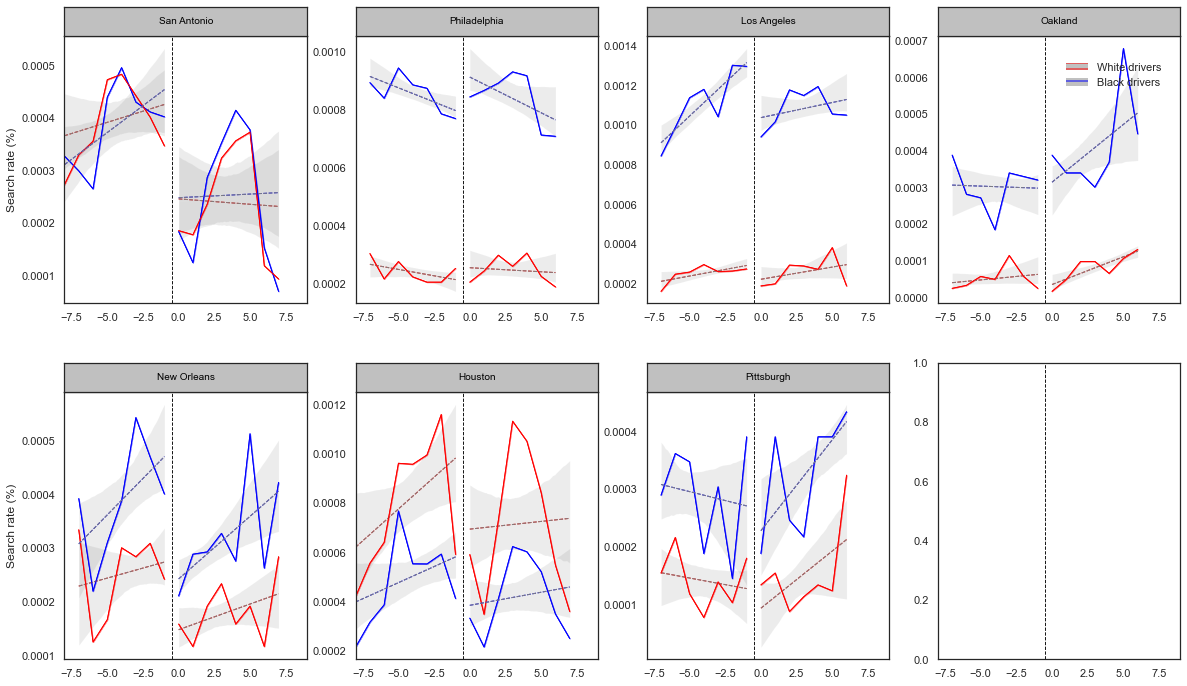

In [98]:
axs = my_init()
colors = {'white':'red', 'black':'blue'}

data = traffic_stops_census_protests
axs = axs.flatten()

for i,city in enumerate(data.city_x.unique()):
    for race in ['white', 'black']:
        first_half = data[data.city_x == city]
        first_half = first_half[first_half.elapsed_time >= 0]
        my_lineplot(first_half, axs[i])
        my_regplot(first_half[first_half.race == race], axs[i], 0, colors[race]) # plotting dashed line
        my_regplot(first_half[first_half.race == race], axs[i], 95, 'grey') # plotting grey background

        second_half = data[data.city_x == city]
        second_half = second_half[second_half.elapsed_time < 0]
        my_lineplot(second_half, axs[i])
        my_regplot(second_half[second_half.race == race], axs[i], 0, colors[race]) # plotting dashed line
        my_regplot(second_half[second_half.race == race], axs[i], 95, 'grey') # plotting grey background

    
    my_title(city, axs[i])
    my_ticker(axs[i])
    
my_ticker(axs[0], ylabel=True)
my_ticker(axs[4], ylabel=True)
my_legend(axs[3])

### Regression

In [27]:
from datetime import datetime, timedelta

def calculateMeanPrePost(number_days):
    dates_of_interest = df_merged_city.date.tolist()
    city_of_interest = df_merged_city.city.tolist()
    race_of_interest = df_merged_city.race.tolist()
    event_name = df_merged_city.Event.tolist()
    source = df_merged_city.Source.tolist()

    pre_days_average = []
    post_days_average = []
    colum = ['date', 'city', 'Event', 'Source', 'race', 'period', 'x_days_stop_mean']
    for idx, date in enumerate(dates_of_interest):
        #Pre period
        pre = traffic_stops_census[(traffic_stops_census['date']>date - timedelta(days=number_days))& (traffic_stops_census['date']<date) 
                                   & (traffic_stops_census['city']==city_of_interest[idx]) & (traffic_stops_census['race']==race_of_interest[idx])]
        pre_days_average.append([date, city_of_interest[idx], event_name[idx], source[idx], race_of_interest[idx],0,pre.stops.mean()])

        #Post period
        post = traffic_stops_census[(traffic_stops_census['date']<date + timedelta(days=number_days))& (traffic_stops_census['date']>date) 
                                   & (traffic_stops_census['city']==city_of_interest[idx]) & (traffic_stops_census['race']==race_of_interest[idx])]
        post_days_average.append([date, city_of_interest[idx], event_name[idx], source[idx], race_of_interest[idx],1 ,post.stops.mean()])



    df_pre_post_stops = pd.concat([pd.DataFrame(pre_days_average, columns=colum), 
            pd.DataFrame(post_days_average, columns=colum)], axis=0)
    return df_pre_post_stops


df_pre_post_stops = calculateMeanPrePost(7)

#Something wrong <--- event on the same day it gets confused! find solution
df_merged_city_pre_post = pd.merge(df_merged_city, df_pre_post_stops, how='inner', on=['city', 'date', 'Event', 'race', 'Source'])
print(len(df_pre_post_stops))
print(len(df_merged_city_pre_post))
#print(len(dates_of_interest))
print(len(df_merged_city))
df_merged_city_pre_post = df_merged_city_pre_post.drop_duplicates()
print(len(df_pre_post_stops))
df_merged_city_pre_post.head(5)


238
246
119
238


,date,race,stops,state,city,short_state,census_2019,percentage,Location,Attendees,Event,Tags,Curated,Source,Total Articles,period,x_days_stop_mean
0,2017-10-13,black,602,Pennsylvania,Philadelphia,PA,670059.072,0.423,"Philadelphia, PA",1.0,Racial Injustice (National Anthem),Civil Rights; For racial justice; National anthem,Yes,http://www.phillyvoice.com/army-vets-mission-t...,1,0,556.000000
1,2017-10-13,black,602,Pennsylvania,Philadelphia,PA,670059.072,0.423,"Philadelphia, PA",1.0,Racial Injustice (National Anthem),Civil Rights; For racial justice; National anthem,Yes,http://www.phillyvoice.com/army-vets-mission-t...,1,1,486.000000
2,2017-10-13,white,115,Pennsylvania,Philadelphia,PA,548086.144,0.346,"Philadelphia, PA",1.0,Racial Injustice (National Anthem),Civil Rights; For racial justice; National anthem,Yes,http://www.phillyvoice.com/army-vets-mission-t...,1,0,127.307692
3,2017-10-13,white,115,Pennsylvania,Philadelphia,PA,548086.144,0.346,"Philadelphia, PA",1.0,Racial Injustice (National Anthem),Civil Rights; For racial justice; National anthem,Yes,http://www.phillyvoice.com/army-vets-mission-t...,1,1,119.846154
4,2017-09-23,black,34,California,Oakland,CA,103061.378,0.238,"Oakland, CA",1.0,Racial Injustice (National Anthem),Civil Rights; For racial justice; National anthem,Yes,http://www.eastbaytimes.com/2017/09/24/as-play...,5,0,47.615385


In [28]:
import statsmodels.formula.api as smf
df_merged_city_pre_post['hit_rate'] = df_merged_city_pre_post['x_days_stop_mean'] * df_merged_city_pre_post['percentage']
df_merged_city_pre_post['articles']  = df_merged_city_pre_post['Total Articles'] 
df_merged_city_pre_post['florida_binary']  = [1 if state == 'FL' else 0 for state in  df_merged_city_pre_post.short_state.tolist()]
mod = smf.ols(formula='hit_rate ~  C(race) + period + period:Attendees:C(race) ', data=df_merged_city_pre_post)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               hit_rate   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.520
Date:                Sun, 13 Dec 2020   Prob (F-statistic):              0.197
Time:                        16:03:55   Log-Likelihood:                -1368.7
No. Observations:                 238   AIC:                             2747.
Df Residuals:                     233   BIC:                             2765.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

## Regresion 2

In [12]:
from datetime import datetime, timedelta

def calculateMeanPrePost(df, df_stops, number_days):
    dates_of_interest = df.date.tolist()
    city_of_interest = df.city.tolist()
    race_of_interest = df.race.tolist()
    url = df.url.tolist()
    #source = df.Source.tolist()

    pre_days_average = []
    post_days_average = []
    colum = ['date', 'city', 'race', 'period', 'url', 'x_days_stop_mean']
    for idx, date in enumerate(dates_of_interest):
        #Pre period
        pre = df_stops[(df_stops['date']>date - timedelta(days=number_days))& (df_stops['date']<date) 
                                   & (df_stops['city']==city_of_interest[idx]) & (df_stops['race']==race_of_interest[idx])]
        pre_days_average.append([date, city_of_interest[idx], race_of_interest[idx],0, url[idx] ,pre.stops.mean()])
        
        
        
        #Post period
        post = df_stops[(df_stops['date']<date + timedelta(days=number_days))& (df_stops['date']>date) 
                                   & (df_stops['city']==city_of_interest[idx]) & (df_stops['race']==race_of_interest[idx])]
        post_days_average.append([date, city_of_interest[idx], race_of_interest[idx],1, url[idx] ,post.stops.mean()])

        

    df_pre_post_stops = pd.concat([pd.DataFrame(pre_days_average, columns=colum), 
            pd.DataFrame(post_days_average, columns=colum)], axis=0)
    print(df_pre_post_stops.columns)
    return df_pre_post_stops


traffic_stops_df


print('protest matches', len(df_merged_traffic_BLM))

df_pre_post_stops = calculateMeanPrePost(df_merged_traffic_BLM, traffic_stops_df, 5)

#Something wrong <--- event on the same day it gets confused! find solution
df_merged_city_pre_post = pd.merge(df_merged_traffic_BLM, df_pre_post_stops, how='inner', on=['city', 'date', 'race', 'url'])

print(len(df_merged_traffic_BLM))
print(len(df_merged_city_pre_post))



protest matches 146
Index(['date', 'city', 'race', 'period', 'url', 'x_days_stop_mean'], dtype='object')
146
292


In [13]:
import statsmodels.formula.api as smf

df_merged_city_pre_post['hit_rate'] = df_merged_city_pre_post['x_days_stop_mean']*df_merged_city_pre_post['race_of_interest_percentage']


#print(df_merged_city_pre_post.head(20))

#df_merged_city_pre_post['articles']  = df_merged_city_pre_post['Total Articles'] 
#df_merged_city_pre_post['florida_binary']  = [1 if state == 'FL' else 0 for state in  df_merged_city_pre_post.short_state.tolist()]
mod = smf.ols(formula='hit_rate ~  C(race) + period + period:popnum:C(race) ', data=df_merged_city_pre_post)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               hit_rate   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.609
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.172
Time:                        20:08:27   Log-Likelihood:                -1725.2
No. Observations:                 292   AIC:                             3460.
Df Residuals:                     287   BIC:                             3479.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       